In [1]:
import pandas as pd
import numpy as np
#!pip install xgboost
import xgboost as xgb
from haversine import haversine

In [2]:
taxi_set = pd.read_csv('cleaned_set.csv')
taxi_set.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,y2,distance1,logdistance1,havers_dist,pickup_min,pickup_sec,pickup_day,pickup_date,pickup_mon,speed
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,...,-4637.567460,1.485567,0.910501,1.498523,24,55,0,14,3,11.856445
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,...,-4640.780951,1.694063,0.991050,1.805510,43,35,6,12,6,9.803672
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,...,-4642.385731,4.492538,1.703390,6.385107,35,24,1,19,1,10.822216
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,...,-4642.781602,0.979350,0.682769,1.485500,32,31,2,6,4,12.465738
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,...,-4636.579512,0.776502,0.574646,1.188590,30,55,5,26,3,9.836608


In [3]:
taxi_set.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed'],
      dtype='object')

### Converting Trip duration in Hours

In [4]:
taxi_set['trip_dur_in_hr']=taxi_set['trip_duration']/3600

In [5]:
taxi_set['trip_dur_in_hr'].describe()

count    1.458487e+06
mean     2.646940e-01
std      8.809655e-01
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      2.399778e+01
Name: trip_dur_in_hr, dtype: float64

max value in 23 hour, we gonna remove trip with duration more than 2h

In [6]:
taxi_set=taxi_set[taxi_set['trip_dur_in_hr'] <= 2]

In [7]:
taxi_set['trip_dur_in_hr'].describe()

count    1.456238e+06
mean     2.322628e-01
std      1.817477e-01
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.980556e-01
max      1.997500e+00
Name: trip_dur_in_hr, dtype: float64

In [9]:
taxi_set.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed', 'trip_dur_in_hr'],
      dtype='object')

In [12]:
def create_datetime(df):

    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

    # Hour of the day
    df['pickup_seconds'] = (df['pickup_sec'] + df['pickup_min'] * 60 + df['pickup_hour'] * 3600)
    df['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in df['pickup_mon']]
    df['quarter']=df['pickup_datetime'].dt.quarter  ## quarter of the year
    df['mid_latitude']=(df['dropoff_latitude']-df['pickup_latitude'])/2
    df['mid_longitude']=(df['dropoff_longitude']-df['pickup_longitude'])/2
    df['night']=[1 if (i==0 or i>=20)  else 0 for i in df['pickup_hour']]
    df['too_late']=[1 if (i<5 and i>0)  else 0 for i in df['pickup_hour']]
    

# Harvesine Distance

def create_distance(df):
    
    #Haversine distance already in the file
    #df['havers_dist'] = df.apply(lambda x: haversine(
        #(x['pickup_latitude'], x['pickup_longitude']),
        #(x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    
    #Manhattan distance
    df['Manhattan_dist']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]
    
    #Chebyshev distance
    df['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]

In [13]:
create_datetime(taxi_set)
create_distance(taxi_set)

‘Lon’ is point A longitude and ‘lat’ is point A latitude
Bearing from point A to B, can be calculated as,

##### β = atan2(X,Y), 
where, X and Y are two quantities and can be calculated as:

##### X = cos lat2 * sin (lon2-lon1)
##### Y = cos lat1 * sin lat2 – sin lat1 * cos lat2 * cos (lon2-lon1)
##### https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/

In [14]:
def bearing_heading(lat1, lon1, lat2, lon2):
    #R = 6371  # in km
    delta = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    
    X = np.cos(lat2) * np.sin(delta)
    Y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta)
    beta = np.arctan2(X, Y)
    
    return np.degrees(beta)

In [15]:
taxi_set['bearing_direction']=[bearing_heading(i,j,k,l) for i,j,k,l in zip(taxi_set['pickup_latitude'], 
                                                                       taxi_set['pickup_longitude'],
                                                                       taxi_set['dropoff_latitude'], 
                                                                       taxi_set['dropoff_longitude'])]

In [16]:
taxi_set.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed', 'trip_dur_in_hr', 'pickup_seconds', 'weather', 'quarter',
       'mid_latitude', 'mid_longitude', 'night', 'too_late', 'Manhattan_dist',
       'Chebyshev_dist', 'bearing_direction'],
      dtype='object')

In [50]:
## drop columns to avoid data type problems in xgboost
train=taxi_set.drop(['id','vendor_id','pickup_datetime','dropoff_datetime','store_and_fwd_flag', 'logduration','trip_dur_in_hr',
                     'pickup_DayHour', 'speed'],1)

In [51]:
train.columns

Index(['Unnamed: 0', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'pickup_hour',
       'x1', 'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'pickup_seconds', 'weather', 'quarter', 'mid_latitude', 'mid_longitude',
       'night', 'too_late', 'Manhattan_dist', 'Chebyshev_dist',
       'bearing_direction'],
      dtype='object')

In [52]:
y=np.log(train['trip_duration'].values + 1)
x=train.drop(['trip_duration'],1)

### xgboost

In [53]:
from sklearn.cross_validation import train_test_split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.2, random_state=1996)

In [54]:
dtrain = xgb.DMatrix(Xtrain, label=ytrain)

In [55]:
dvalid = xgb.DMatrix(Xvalid, label=yvalid)
#dtest = xgb.DMatrix(test[feature_names].values)
evallist = [(dtrain, 'train'), (dvalid, 'valid')]

num_round = 100000
#From mayank's kernel
xgb_pars = {'min_child_weight': 10, 'eta': 0.03, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1, 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [56]:
model = xgb.train(xgb_pars, dtrain, num_round, evallist, early_stopping_rounds=90, maximize=False, verbose_eval=100)

[0]	train-rmse:5.83168	valid-rmse:5.83036
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 90 rounds.
[100]	train-rmse:0.458548	valid-rmse:0.463523
[200]	train-rmse:0.334218	valid-rmse:0.349092
[300]	train-rmse:0.318866	valid-rmse:0.341512
[400]	train-rmse:0.308958	valid-rmse:0.337921
[500]	train-rmse:0.302384	valid-rmse:0.336034
[600]	train-rmse:0.297763	valid-rmse:0.334852
[700]	train-rmse:0.294046	valid-rmse:0.334041
[800]	train-rmse:0.290737	valid-rmse:0.333238
[900]	train-rmse:0.287753	valid-rmse:0.332768
[1000]	train-rmse:0.284994	valid-rmse:0.332166
[1100]	train-rmse:0.282497	valid-rmse:0.331691
[1200]	train-rmse:0.279847	valid-rmse:0.331104
[1300]	train-rmse:0.277578	valid-rmse:0.330747
[1400]	train-rmse:0.275701	valid-rmse:0.330495
[1500]	train-rmse:0.273923	valid-rmse:0.33027
[1600]	train-rmse:0.272006	valid-rmse:0.330002
[1700]	train-rmse:0.270111	valid-rmse:0.329717
[1800]	train-rmse:0.2684

In [57]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.32484


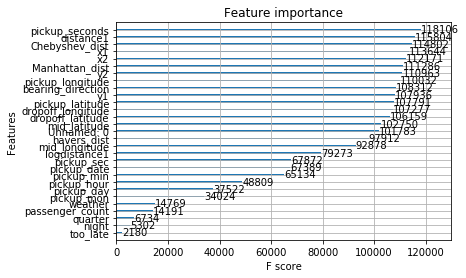

In [58]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, ax=None, height=0.2, xlim=None,
                    ylim=None, title='Feature importance',
                    xlabel='F score', ylabel='Features',
                    importance_type='weight', max_num_features=None,
                    grid=True)
plt.show()


In [59]:
import pickle
pickle.dump(model,open('xgb_pred.sav','wb'))

# TEST

In [93]:
test_dataset = pd.read_csv('test.csv')

In [94]:
test_dataset.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [95]:
#Latitude and Longitude to cartesian cordindates converesion
# Assuming Earth as sphere not ellipsoid 
def cartesian_x(lat,lon):
    lat=np.radians(lat)
    lon=np.radians(lon)
    R=6371.0
    x = R * np.cos(lat) * np.cos(lon)
    return x
def cartesian_y(lat,lon):
    lat=np.radians(lat)
    lon=np.radians(lon)
    R=6371.0
    y = R * np.cos(lat) * np.sin(lon)
    return y
# extracting cartesian x,y cordinates form latitude and longitude
test_dataset['x1']=[cartesian_x(i,j) for i,j in zip(test_dataset['pickup_latitude'],test_dataset['pickup_longitude'])]
test_dataset['y1']=[cartesian_y(i,j) for i,j in zip(test_dataset['pickup_latitude'],test_dataset['pickup_longitude'])]
test_dataset['x2']=[cartesian_x(i,j) for i,j in zip(test_dataset['dropoff_latitude'],test_dataset['dropoff_longitude'])]
test_dataset['y2']=[cartesian_y(i,j) for i,j in zip(test_dataset['dropoff_latitude'],test_dataset['dropoff_longitude'])]

In [96]:
def euclidean_distance(a1,b1,a2,b2):
    dist=np.sqrt((a2-a1)**2+(b2-b1)**2)
    return dist
    
test_dataset['distance1']=[euclidean_distance(i,j,k,l) for i,j,k,l in zip(test_dataset['x1'], 
                                                                          test_dataset['y1'],
                                                                          test_dataset['x2'], 
                                                                          test_dataset['y2'])]

test_dataset['logdistance1']=np.log(test_dataset['distance1']+1)

In [99]:
def create_distance1(df):
    
    #Haversine distance already in the file
    df['havers_dist'] = df.apply(lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    
    #Manhattan distance
    df['Manhattan_dist']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]
    
    #Chebyshev distance
    df['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]

def create_datetime_weekmont(df):
    
    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_min'] = df['pickup_datetime'].dt.minute
    df['pickup_sec'] = df['pickup_datetime'].dt.second
    df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_date'] = df['pickup_datetime'].dt.day
    df['pickup_mon'] = df['pickup_datetime'].dt.month

In [100]:
create_distance1(test_dataset)
create_datetime_weekmont(test_dataset)
create_datetime(test_dataset)

test_dataset['bearing_direction']=[bearing_heading(i,j,k,l) for i,j,k,l in zip(test_dataset['pickup_latitude'], 
                                                                       test_dataset['pickup_longitude'],
                                                                       test_dataset['dropoff_latitude'], 
                                                                       test_dataset['dropoff_longitude'])]



In [101]:
test_dataset.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'x1', 'y1', 'x2', 'y2',
       'distance1', 'logdistance1', 'havers_dist', 'Manhattan_dist',
       'Chebyshev_dist', 'pickup_hour', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'pickup_seconds', 'weather',
       'quarter', 'mid_latitude', 'mid_longitude', 'night', 'too_late',
       'bearing_direction'],
      dtype='object')

In [102]:
## drop columns to avoid data type problems in xgboost
test=test_dataset.drop(['id','vendor_id','pickup_datetime','store_and_fwd_flag'],1)

In [108]:
test.insert(0, 'Unnamed: 0', range(0, len(test)))

In [110]:
test.columns


Index(['Unnamed: 0', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'x1', 'y1', 'x2', 'y2',
       'distance1', 'logdistance1', 'havers_dist', 'Manhattan_dist',
       'Chebyshev_dist', 'pickup_hour', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'pickup_seconds', 'weather',
       'quarter', 'mid_latitude', 'mid_longitude', 'night', 'too_late',
       'bearing_direction'],
      dtype='object')

In [111]:
x.columns

Index(['Unnamed: 0', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'x1', 'y1',
       'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist', 'pickup_min',
       'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'pickup_seconds', 'weather', 'quarter', 'mid_latitude', 'mid_longitude',
       'night', 'too_late', 'Manhattan_dist', 'Chebyshev_dist',
       'bearing_direction'],
      dtype='object')

In [114]:
model=pickle.load(open('xgb_pred.sav','rb'))

dtest = xgb.DMatrix(test[['Unnamed: 0', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'x1', 'y1',
       'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist', 'pickup_min',
       'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'pickup_seconds', 'weather', 'quarter', 'mid_latitude', 'mid_longitude',
       'night', 'too_late', 'Manhattan_dist', 'Chebyshev_dist',
       'bearing_direction'
    
]])
ytest = model.predict(dtest)


In [117]:
np.exp(np.round(ytest[1:10]))-1

array([ 402.4288,  402.4288, 1095.6332,  402.4288, 1095.6332, 1095.6332,
       1095.6332, 2979.958 ,  402.4288], dtype=float32)

In [118]:
test['trip_duration'] = np.round(np.exp(ytest)) - 1

In [120]:
test_dataset['trip_duration']=np.round(np.exp(ytest)) - 1

In [121]:
test_dataset[['id', 'trip_duration']].to_csv('submission10.csv', index=False)